# World Generation - 10-Stage Pipeline with Auto Location Detection

**Complete hierarchical map generation workflow:**
1. **Stage 0**: Configuration (8 story bibles + central data tracking)
2. **Stage 1**: Generate world prompt (with thinking)
3. **Stage 2**: Generate world image
4. **Stage 3**: Auto Cropper - Detect locations with 16×16 grid 🆕
5. **Stage 4**: Crop viewer (manual or location-based)
6. **Stage 5**: Generate tile prompt (for zoomed region)
7. **Stage 6**: Generate tile image
8. **Stage 7**: Context-aware tile generation (uses siblings + parent)
9. **Stage 8**: Hierarchy viewer (visualize all layers)

**Each stage is self-contained - change ACTIVE_WORLD at the top of each cell!**

**Now using LiteLLM with OpenRouter for all API calls!**

---
## 📦 Setup
---

In [47]:
import litellm
import json
import base64
import hashlib
from PIL import Image, ImageDraw, ImageFont
import io
import matplotlib.pyplot as plt
from pathlib import Path
import os
from dotenv import load_dotenv
from typing import Dict, List, Tuple, Optional
from pydantic import BaseModel, Field
import numpy as np

load_dotenv()

# Set OpenRouter API key for LiteLLM
os.environ["OPENROUTER_API_KEY"] = os.getenv('OPENROUTER_API_KEY', 'YOUR_API_KEY_HERE')

# Create output directories
os.makedirs('outputs', exist_ok=True)
os.makedirs('outputs/cache_litellm', exist_ok=True)
os.makedirs('outputs/tiles', exist_ok=True)
os.makedirs('outputs/grids', exist_ok=True)

print("✓ Ready (LiteLLM + OpenRouter)")

✓ Ready (LiteLLM + OpenRouter)


---
# ⚙️ STAGE 0: Configuration
---

In [48]:
# === MODELS (LiteLLM with OpenRouter) ===
REASONING_MODEL = "openrouter/google/gemini-2.5-flash"  # For prompt generation + location detection
IMAGE_MODEL = "openrouter/google/gemini-2.5-flash-image"  # For image generation

# === PARAMETERS ===
TEMPERATURE = 0  # 0 = deterministic, 1 = creative
USE_THINKING = True  # Enable thinking for both reasoning and image models
THINKING_BUDGET_TOKENS = 10000

# === IMAGE SETTINGS ===
OUTPUT_RESOLUTION = 1024  # Always square (1024×1024)
ZOOM_FACTOR = 64  # Each tile is 64× more detailed than parent

# === GRID SETTINGS ===
GRID_SIZE = 16  # 16×16 grid for location detection
ENABLE_JSON_VALIDATION = True  # Client-side validation

# === CACHING ===
USE_CACHE = True
CACHE_DIR = "outputs/cache_litellm"

# Enable JSON schema validation for LiteLLM
litellm.enable_json_schema_validation = ENABLE_JSON_VALIDATION

# === WORLD DATA TRACKING ===
WORLD_DATA_PATH = "outputs/world_data.json"

def load_world_data() -> Dict:
    """Load central world data tracking from JSON"""
    if os.path.exists(WORLD_DATA_PATH):
        with open(WORLD_DATA_PATH, 'r') as f:
            return json.load(f)
    return {}

def save_world_data(data: Dict):
    """Save central world data tracking to JSON"""
    with open(WORLD_DATA_PATH, 'w') as f:
        json.dump(data, f, indent=2)

def init_world(world_name: str, size_meters: int) -> Dict:
    """Initialize a world in the data structure if it doesn't exist"""
    data = load_world_data()
    if world_name not in data:
        data[world_name] = {
            "size_meters": size_meters,
            "layers": []
        }
        save_world_data(data)
    return data

def add_layer(world_name: str, layer_info: Dict) -> int:
    """Add a new layer to a world, returns layer_id"""
    data = load_world_data()
    if world_name not in data:
        raise ValueError(f"World {world_name} not initialized")
    
    layer_id = len(data[world_name]["layers"])
    layer_info["layer_id"] = layer_id
    data[world_name]["layers"].append(layer_info)
    save_world_data(data)
    return layer_id

def get_layer(world_name: str, layer_id: int) -> Optional[Dict]:
    """Get a specific layer from a world"""
    data = load_world_data()
    if world_name in data and layer_id < len(data[world_name]["layers"]):
        return data[world_name]["layers"][layer_id]
    return None

def get_siblings(world_name: str, layer_id: int) -> List[Dict]:
    """Get all sibling layers (same parent, same depth)"""
    layer = get_layer(world_name, layer_id)
    if not layer:
        return []
    
    data = load_world_data()
    siblings = []
    for l in data[world_name]["layers"]:
        if l["depth"] == layer["depth"] and l["parent_id"] == layer["parent_id"] and l["layer_id"] != layer_id:
            siblings.append(l)
    return siblings

# =================================================================
# 🌍 8 STORY BIBLES - Change ACTIVE_WORLD in each stage
# =================================================================

STORY_BIBLES = {
    "eldermyst": {
        "size_meters": 64000,
        "bible": """
# World: Eldermyst

## Geography
- Large temperate continent spanning most of the map
- Ocean surrounds the continent on all sides
- Major river (Silverflow) runs north to south through center
- Mountain range along western edge with snow-capped peaks
- Dense forests in northern third of continent
- Fertile plains in southern regions
- Coastal areas along eastern shore
- Small islands off the eastern coast

## Major Settlements
- **Thornhaven** (Capital): Large walled city at center on Silverflow River
- **Eastport**: Coastal trading city on eastern shore
- **Millbrook**: Agricultural village in southern plains
- **Ironpeak**: Mining settlement in western mountains
- **Woodhaven**: Forest village in the north
"""
    },
    
    "sunscorch": {
        "size_meters": 80000,
        "bible": """
# World: Sunscorch Expanse

## Geography
- Vast desert continent dominating the center
- Ancient dried sea bed in the east (cracked salt flats)
- Rocky badlands and mesas in the west
- Chain of oases along underground river route
- Small ocean on northern edge
- Sand dune seas in the south (golden dunes)
- Rare patches of scrubland and hardy vegetation
- Canyon systems carved by ancient rivers

## Major Settlements
- **Mirage City**: Capital built around largest oasis in center
- **Saltstead**: Trading post on salt flats
- **Dunewatch**: Nomadic settlement near southern dunes
- **Redrock**: Mining outpost in western mesas
- **Oasis-7**: Small settlement on oasis chain
"""
    },
    
    "thousand_isles": {
        "size_meters": 96000,
        "bible": """
# World: Thousand Isles Archipelago

## Geography
- Vast ocean covering 70% of map
- Hundreds of islands ranging from tiny to large
- Three major island chains in arc formation
- Volcanic island cluster in southwest (active volcano)
- Coral reef systems between islands (lighter blue water)
- One large central island with mountains
- Tropical climate with lush vegetation on all islands
- Deep ocean trenches between island chains (darker blue)

## Major Settlements
- **Tidehaven**: Port city on largest central island
- **Coral Bay**: Trading hub on reef system
- **Ashfall**: Settlement near volcanic islands
- **Stormbreak**: Fishing village on eastern chain
- **Pearl Cove**: Southern island town
"""
    },
    
    "frostheim": {
        "size_meters": 72000,
        "bible": """
# World: Frostheim

## Geography
- Frozen tundra covering most of continent
- Massive ice sheets in north and south (white)
- Glacial valleys running east to west
- Rocky highlands in center (exposed stone)
- Frozen sea surrounding continent
- Geothermal hot springs creating patches of green
- Ice-carved fjords along coasts
- Aurora visible as shimmering lights (northern regions)

## Major Settlements
- **Frostspire**: Capital built in geothermal valley
- **Icehome**: Settlement on central highlands
- **Warmspring**: Village around hot springs
- **Glaciersedge**: Outpost on southern ice sheet
- **Fjordwatch**: Coastal settlement in fjord
"""
    },
    
    "pyroclasm": {
        "size_meters": 56000,
        "bible": """
# World: Pyroclasm

## Geography
- Volcanic continent with active lava flows
- Three massive active volcanoes in triangular formation
- Rivers of lava connecting volcanoes (red/orange)
- Obsidian plains (black glass fields)
- Ash wastelands (gray areas)
- Rare fertile valleys with heat-resistant vegetation
- Sulfur lakes (yellow)
- Geothermal vents releasing steam
- Dark ocean surrounding the continent

## Major Settlements
- **Emberheart**: Capital in protected valley
- **Ashtown**: Settlement on obsidian plains
- **Lavafont**: Mining outpost near lava flows
- **Steamhaven**: Town built on geothermal vents
- **Cinderpeak**: Monastery on dormant volcano
"""
    },
    
    "verdant_crown": {
        "size_meters": 88000,
        "bible": """
# World: Verdant Crown

## Geography
- Massive rainforest jungle covering entire continent
- Canopy so dense it appears as solid green from above
- Network of rivers cutting through jungle (visible as blue lines)
- Ancient temple ruins scattered throughout (stone structures)
- Waterfall system in northern highlands
- Swamplands in southern lowlands (darker green)
- Clearings where villages have been built
- Massive trees creating dark patches (old growth forest)

## Major Settlements
- **Canopy City**: Capital built in treetops
- **Roothold**: Ground-level settlement near rivers
- **Vinereach**: Village on jungle edge
- **Mistfall**: Town near waterfalls
- **Temple Grounds**: Settlement around ancient ruins
"""
    },
    
    "skyreach": {
        "size_meters": 64000,
        "bible": """
# World: Skyreach Dominion

## Geography
- Floating islands suspended in the sky
- Clouds below the islands (white)
- Islands connected by massive chain bridges
- One enormous central island (capital location)
- Smaller islands in orbital patterns around center
- Waterfalls cascading off island edges into clouds
- Crystal formations growing on island undersides
- Airship routes between major islands
- Sky whales migrating through the map

## Major Settlements
- **Aetherpeak**: Steampunk capital on central island
- **Cloudrest**: Town on western floating island
- **Bridgeport**: Settlement at major chain intersection
- **Skyforge**: Industrial city with smokestacks
- **Windmill Station**: Farming community on eastern isle
"""
    },
    
    "ashfall_wastes": {
        "size_meters": 76000,
        "bible": """
# World: Ashfall Wastes

## Geography
- Post-apocalyptic wasteland with ruined cities
- Cracked earth and dried riverbeds
- Skeletal remains of ancient megastructures
- Toxic green zones (radiation/poison)
- Dust storms visible as brown haze in east
- Oasis settlements built in ruins
- Scrap metal mountains in industrial zones
- Rare patches of mutated vegetation (sickly colors)
- Underground bunker entrances visible as dark spots

## Major Settlements
- **Haven**: Fortified settlement in ancient stadium
- **Rust Town**: Scavenger community in factory ruins
- **Greenlight**: Settlement avoiding toxic zones
- **Vault 7**: Underground bunker city (surface entrance)
- **Scrapper's End**: Trading post in metal mountains
"""
    }
}

# === DISPLAY CONFIG ===
print("=" * 70)
print("STAGE 0: CONFIGURATION LOADED (LiteLLM + OpenRouter)")
print("=" * 70)
print(f"Available worlds: {', '.join(STORY_BIBLES.keys())}")
print(f"Models: {REASONING_MODEL} → {IMAGE_MODEL}")
print(f"Temperature: {TEMPERATURE}")
print(f"Thinking: {'✓ ON' if USE_THINKING else '✗ OFF'} ({THINKING_BUDGET_TOKENS} tokens)")
print(f"Grid size: {GRID_SIZE}×{GRID_SIZE} for location detection")
print(f"Zoom factor: {ZOOM_FACTOR}× per level")
print(f"Cache: {'✓ ON' if USE_CACHE else '✗ OFF'}")
print(f"World data: {WORLD_DATA_PATH}")
print("=" * 70)
print("\n✓ Change ACTIVE_WORLD in each stage cell to select world")

STAGE 0: CONFIGURATION LOADED (LiteLLM + OpenRouter)
Available worlds: eldermyst, sunscorch, thousand_isles, frostheim, pyroclasm, verdant_crown, skyreach, ashfall_wastes
Models: openrouter/google/gemini-2.5-flash → openrouter/google/gemini-2.5-flash-image
Temperature: 0
Thinking: ✓ ON (10000 tokens)
Grid size: 16×16 for location detection
Zoom factor: 64× per level
Cache: ✓ ON
World data: outputs/world_data.json

✓ Change ACTIVE_WORLD in each stage cell to select world


---
# 🧠 STAGE 1: Generate World Prompt
---

In [57]:
# === ACTIVE WORLD SELECTION ===
ACTIVE_WORLD = "eldermyst"  # <-- CHANGE THIS
WORLD_SIZE_METERS = STORY_BIBLES[ACTIVE_WORLD]["size_meters"]
WORLD_BIBLE = STORY_BIBLES[ACTIVE_WORLD]["bible"]

# === MODEL CONFIG ===
REASONING_MODEL = "openrouter/google/gemini-2.5-flash"
USE_THINKING = True
THINKING_BUDGET_TOKENS = 10000
TEMPERATURE = 0

# === SETTINGS ===
OUTPUT_RESOLUTION = 1024
USE_CACHE = True
CACHE_DIR = "outputs/cache_litellm"

# === PROMPT GENERATION TEMPLATE ===

PROMPT_TEMPLATE = """
You are a fantasy world map generation expert. Create a detailed prompt for generating a pixel art world map.

**World Definition:**
{world_bible}

**Technical Specifications:**
- Coverage: {size_m:,} meters × {size_m:,} meters ({size_km:.0f} km × {size_km:.0f} km)
- Output: {resolution}×{resolution} pixels (square)
- Scale: 1 pixel = {meters_per_pixel:.1f} meters

**Your Task:**
Generate a detailed image generation prompt that:
1. Describes the COMPLETE world map layout based on the world bible
2. Accounts for the scale - what features are visible at {meters_per_pixel:.1f} meters per pixel?
3. Specifies exact placement of continents, oceans, mountains, rivers, forests, and all terrain
4. Places all settlements mentioned in the world bible
5. Ensures the map fills the entire square canvas
6. Uses appropriate colors and textures for each terrain type
7. Captures the unique atmosphere and theme of this world

**CRITICAL REQUIREMENTS:**
- DO NOT include any text labels, names, or legends in the image
- The map should be purely visual with no written text

Be very specific about locations, colors, and spatial relationships. Output ONLY the image generation prompt.
"""

# === HELPER FUNCTIONS ===

def compute_cache_key(data):
    return hashlib.sha256(json.dumps(data, sort_keys=True).encode()).hexdigest()

def get_cache(key):
    if not USE_CACHE:
        return None
    cache_file = Path(CACHE_DIR) / f"{key}.json"
    return json.load(open(cache_file)) if cache_file.exists() else None

def save_cache(key, data):
    if USE_CACHE:
        with open(Path(CACHE_DIR) / f"{key}.json", 'w') as f:
            json.dump(data, f)

# === GENERATE PROMPT ===

# Initialize world in data structure
init_world(ACTIVE_WORLD, WORLD_SIZE_METERS)

print("\n" + "="*70)
print(f"STAGE 1: GENERATING PROMPT FOR {ACTIVE_WORLD.upper()}")
print("="*70)
print(f"World size: {WORLD_SIZE_METERS/1000:.0f}km × {WORLD_SIZE_METERS/1000:.0f}km")
print(f"Scale: 1 pixel = {WORLD_SIZE_METERS/OUTPUT_RESOLUTION:.1f} meters")

meters_per_pixel = WORLD_SIZE_METERS / OUTPUT_RESOLUTION
size_km = WORLD_SIZE_METERS / 1000

prompt_request = PROMPT_TEMPLATE.format(
    world_bible=WORLD_BIBLE,
    size_m=WORLD_SIZE_METERS,
    size_km=size_km,
    resolution=OUTPUT_RESOLUTION,
    meters_per_pixel=meters_per_pixel
)

# Check cache
cache_key = compute_cache_key({
    'model': REASONING_MODEL,
    'prompt': prompt_request,
    'temp': TEMPERATURE,
    'thinking': USE_THINKING
})

cached = get_cache(cache_key)
if cached:
    world_prompt = cached['result']
    print(f"🎯 Using cached prompt ({len(world_prompt)} chars)")
else:
    print(f"🧠 Calling {REASONING_MODEL} with LiteLLM...")
    print(f"   Temperature: {TEMPERATURE}")
    print(f"   Thinking: {USE_THINKING}")
    
    try:
        response = litellm.completion(
            model=REASONING_MODEL,
            messages=[{"role": "user", "content": prompt_request}],
            temperature=TEMPERATURE,
        )
        
        world_prompt = response.choices[0].message.content
        save_cache(cache_key, {'result': world_prompt})
        print(f"   ✓ Generated ({len(world_prompt)} chars)")
    except Exception as e:
        print(f"   ❌ Error: {e}")
        world_prompt = None

# Display result
if world_prompt:
    print("\n📝 Generated Prompt:")
    print("-" * 70)
    print(world_prompt)
    print("-" * 70)
    print(f"\n✓ Stored in variable: world_prompt")
else:
    print("\n❌ Prompt generation failed")


STAGE 1: GENERATING PROMPT FOR ELDERMYST
World size: 64km × 64km
Scale: 1 pixel = 62.5 meters
🧠 Calling openrouter/google/gemini-2.5-flash with LiteLLM...
   Temperature: 0
   Thinking: True
   ✓ Generated (5452 chars)

📝 Generated Prompt:
----------------------------------------------------------------------
```
pixel art world map, 1024x1024 pixels, top-down view, fantasy style, no text labels, no legends.

**Overall Layout:** A single large, roughly rectangular continent fills the majority of the canvas, centered horizontally and vertically. The continent is surrounded on all sides by a vast, deep blue ocean. The map should feel expansive and ancient.

**Ocean:**
*   **Color:** Deep, rich blue (#003366) for the main ocean, fading slightly to a lighter blue (#006699) near coastlines.
*   **Texture:** Subtle, repeating wave patterns, very small and pixelated, indicating water movement.

**Continent - General Terrain:**
*   **Coastlines:** Irregular, jagged, and varied, with small cov

---
# 🎨 STAGE 2: Generate World Image
---

In [60]:
# === ACTIVE WORLD SELECTION ===
ACTIVE_WORLD = "eldermyst"  # <-- CHANGE THIS
WORLD_SIZE_METERS = STORY_BIBLES[ACTIVE_WORLD]["size_meters"]
WORLD_BIBLE = STORY_BIBLES[ACTIVE_WORLD]["bible"]

# === MODEL CONFIG ===
IMAGE_MODEL = "openrouter/google/gemini-2.5-flash-image"
USE_THINKING = True
THINKING_BUDGET_TOKENS = 10000

# === SETTINGS ===
OUTPUT_RESOLUTION = 1024
USE_CACHE = True
CACHE_DIR = "outputs/cache_litellm"

# === VISUAL STYLE INSTRUCTIONS ===

VISUAL_INSTRUCTIONS = """
## Visual Style Requirements

**Pixel Art Style:**
- 16-bit pixel art aesthetic (SNES era: Chrono Trigger, Final Fantasy VI, Zelda: A Link to the Past)
- Top-down orthogonal view (birds-eye, no perspective)
- Clean, crisp pixels with careful dithering for textures
- Consistent lighting from top-left

**Color Palette:**
- Use vibrant, saturated colors appropriate to the world theme
- Clear distinction between terrain types
- Dithering for texture variation
- High contrast for readability
- **CRITICAL: CLEAR BORDER COLORS between terrain types (land/water, forest/plains, mountain/valley, etc.)**
  - These borders enable automatic segmentation
  - Use distinct border colors between different terrain sections
  - DO NOT hardcode the color palette except for these border colors

**Technical:**
- Output must be exactly 1024×1024 pixels
- Square aspect ratio
- All features clearly distinguishable
- Settlements shown appropriately for scale
- Natural features (rivers, roads, etc.) should be visible but appropriately sized
- **NO TEXT in the image - no labels, names, legends, or written words**
"""

# === HELPER FUNCTIONS ===

def compute_cache_key(data):
    return hashlib.sha256(json.dumps(data, sort_keys=True).encode()).hexdigest()

def get_cache(key):
    if not USE_CACHE:
        return None
    cache_file = Path(CACHE_DIR) / f"{key}.json"
    return json.load(open(cache_file)) if cache_file.exists() else None

def save_cache(key, data):
    if USE_CACHE:
        with open(Path(CACHE_DIR) / f"{key}.json", 'w') as f:
            json.dump(data, f)

def decode_image(data_url):
    if data_url.startswith('data:image'):
        data_url = data_url.split(',')[1]
    return Image.open(io.BytesIO(base64.b64decode(data_url)))

def show_image(img, title=""):
    if isinstance(img, str):
        img = decode_image(img)
    plt.figure(figsize=(12, 12))
    plt.imshow(img)
    plt.axis('off')
    plt.title(title, fontsize=14, pad=10)
    plt.tight_layout()
    plt.show()

# === GENERATE IMAGE ===

if 'world_prompt' not in globals() or world_prompt is None:
    print("\n⚠️  Run Stage 1 first to generate the prompt!")
else:
    print("\n" + "="*70)
    print(f"STAGE 2: GENERATING IMAGE FOR {ACTIVE_WORLD.upper()}")
    print("="*70)
    print(f"World size: {WORLD_SIZE_METERS/1000:.0f}km × {WORLD_SIZE_METERS/1000:.0f}km")
    print(f"Scale: 1 pixel = {WORLD_SIZE_METERS/OUTPUT_RESOLUTION:.1f} meters")
    
    # Combine all context
    full_prompt = f"{world_prompt}\n\n---\n\n{VISUAL_INSTRUCTIONS}"
    
    # Check cache
    cache_key = compute_cache_key({
        'model': IMAGE_MODEL,
        'prompt': full_prompt,
        'thinking': USE_THINKING
    })
    
    cached = get_cache(cache_key)
    if cached:
        world_image_b64 = cached['result']
        print(f"🎯 Using cached image")
    else:
        print(f"🎨 Calling {IMAGE_MODEL} with LiteLLM...")
        
        try:
            response = litellm.completion(
                model=IMAGE_MODEL,
                messages=[{"role": "user", "content": full_prompt}],
            )
            
            # Access image from LiteLLM response
            if hasattr(response.choices[0].message, 'image') and response.choices[0].message.image:
                world_image_b64 = response.choices[0].message.image["url"]
                save_cache(cache_key, {'result': world_image_b64})
                print(f"   ✓ Generated")
            else:
                print("   ❌ No image in response")
                world_image_b64 = None
        except Exception as e:
            print(f"   ❌ Error: {e}")
            world_image_b64 = None
    
    # Save and display
    if world_image_b64:
        img = decode_image(world_image_b64)
        output_path = f"outputs/{ACTIVE_WORLD}_layer0_{WORLD_SIZE_METERS/1000:.0f}km.png"
        img.save(output_path)
        print(f"\n💾 Saved: {output_path}")
        
        # Add to world data
        layer_info = {
            "depth": 0,
            "coordinates": {
                "x_m": 0,
                "y_m": 0,
                "width_m": WORLD_SIZE_METERS,
                "height_m": WORLD_SIZE_METERS
            },
            "size_m": WORLD_SIZE_METERS,
            "parent_id": None,
            "children": [],
            "prompt": world_prompt[:500] + "...",
            "image_path": output_path,
            "locations": None  # Will be filled by Stage 3
        }
        layer_id = add_layer(ACTIVE_WORLD, layer_info)
        print(f"📊 Added to world data as layer {layer_id}")
        
        show_image(
            img,
            f"{ACTIVE_WORLD.upper()}: {WORLD_SIZE_METERS/1000:.0f}km × {WORLD_SIZE_METERS/1000:.0f}km | "
            f"Scale: 1px = {WORLD_SIZE_METERS/OUTPUT_RESOLUTION:.1f}m | Layer {layer_id}"
        )
    else:
        print("\n❌ Image generation failed")


STAGE 2: GENERATING IMAGE FOR ELDERMYST
World size: 64km × 64km
Scale: 1 pixel = 62.5 meters
🎨 Calling openrouter/google/gemini-2.5-flash-image with LiteLLM...
   ❌ No image in response

❌ Image generation failed


---
# 🗺️ STAGE 3: Auto Cropper - Location Detection 🆕
---
Automatically detect and catalog all locations using 16×16 grid + structured outputs

In [51]:
# === ACTIVE WORLD SELECTION ===
ACTIVE_WORLD = "eldermyst"  # <-- CHANGE THIS
WORLD_BIBLE = STORY_BIBLES[ACTIVE_WORLD]["bible"]

# === MODEL CONFIG ===
REASONING_MODEL = "openrouter/google/gemini-2.5-flash"
USE_THINKING = True
THINKING_BUDGET_TOKENS = 10000
TEMPERATURE = 0

# === GRID SETTINGS ===
GRID_SIZE = 16  # 16×16 grid
OUTPUT_RESOLUTION = 1024
USE_CACHE = True
CACHE_DIR = "outputs/cache_litellm"

# === PYDANTIC MODELS FOR STRUCTURED OUTPUT ===

class TileLocation(BaseModel):
    row: int = Field(..., description="Row number 1-16", ge=1, le=16)
    column: str = Field(..., description="Column letter A-P", pattern="^[A-P]$")

class Location(BaseModel):
    name: str = Field(..., description="Name of the location")
    description: str = Field(..., description="Brief description")
    type: str = Field(..., description="Type: settlement, mountain, river, forest, ocean, plains, etc")
    tiles: List[TileLocation] = Field(..., description="All tiles this location spans")
    approximate_center: TileLocation = Field(..., description="Primary tile where location is most prominent")

class MapLocations(BaseModel):
    locations: List[Location] = Field(..., description="All identified locations")

# === LOCATION DETECTION PROMPT ===

LOCATION_DETECTION_PROMPT = """
You are analyzing a fantasy world map to identify and catalog all important locations.

**World Context:**
{world_bible}

**Map Generation Details:**
{world_prompt}

**Grid System:**
The attached image shows the complete world map with a {grid_size}×{grid_size} grid overlay:
- Columns: A-P (left to right)
- Rows: 1-16 (top to bottom)
- Each tile is {tile_size_m}m × {tile_size_m}m

**Your Task:**
Identify ALL significant locations visible on the map including:
1. Settlements (cities, towns, villages)
2. Geographic features (mountains, rivers, forests, plains, etc.)
3. Water bodies (oceans, seas, lakes)
4. Any other notable features

For each location:
- Provide its name (from the world bible or descriptive name if unnamed)
- Classify its type
- List ALL grid tiles it occupies (locations can span multiple tiles)
- Identify the primary/center tile

Be comprehensive. Include all locations mentioned in the world bible AND visible in the image.
"""

# === HELPER FUNCTIONS ===

def compute_cache_key(data):
    return hashlib.sha256(json.dumps(data, sort_keys=True).encode()).hexdigest()

def get_cache(key):
    if not USE_CACHE:
        return None
    cache_file = Path(CACHE_DIR) / f"{key}.json"
    return json.load(open(cache_file)) if cache_file.exists() else None

def save_cache(key, data):
    if USE_CACHE:
        with open(Path(CACHE_DIR) / f"{key}.json", 'w') as f:
            json.dump(data, f)

def encode_image(img):
    buffered = io.BytesIO()
    img.save(buffered, format="PNG")
    img_str = base64.b64encode(buffered.getvalue()).decode()
    return f"data:image/png;base64,{img_str}"

def create_gridded_image(img: Image.Image, grid_size: int = 16) -> Image.Image:
    """Create image with grid overlay and labels"""
    gridded = img.copy()
    draw = ImageDraw.Draw(gridded)
    
    width, height = img.size
    cell_width = width // grid_size
    cell_height = height // grid_size
    
    # Try to load a font, fallback to default
    try:
        font = ImageFont.truetype("/System/Library/Fonts/Helvetica.ttc", 16)
    except:
        font = ImageFont.load_default()
    
    # Draw vertical lines and column labels (A-P)
    columns = "ABCDEFGHIJKLMNOP"
    for i in range(grid_size + 1):
        x = i * cell_width
        draw.line([(x, 0), (x, height)], fill="yellow", width=2)
        if i < grid_size:
            # Label at top
            label = columns[i]
            draw.text((x + cell_width//2 - 5, 5), label, fill="yellow", font=font)
    
    # Draw horizontal lines and row labels (1-16)
    for i in range(grid_size + 1):
        y = i * cell_height
        draw.line([(0, y), (width, y)], fill="yellow", width=2)
        if i < grid_size:
            # Label at left
            label = str(i + 1)
            draw.text((5, y + cell_height//2 - 8), label, fill="yellow", font=font)
    
    return gridded

def show_image(img, title=""):
    if isinstance(img, str):
        img = Image.open(img)
    plt.figure(figsize=(14, 14))
    plt.imshow(img)
    plt.axis('off')
    plt.title(title, fontsize=14, pad=10)
    plt.tight_layout()
    plt.show()

# === DETECT LOCATIONS ===

if 'world_prompt' not in globals() or world_prompt is None:
    print("\n⚠️  Run Stage 1 and 2 first!")
else:
    print("\n" + "="*70)
    print(f"STAGE 3: AUTO LOCATION DETECTION FOR {ACTIVE_WORLD.upper()}")
    print("="*70)
    
    # Get layer 0 (world map)
    layer = get_layer(ACTIVE_WORLD, 0)
    if not layer:
        print("\n❌ Layer 0 not found. Run Stage 2 first!")
    else:
        print(f"Creating {GRID_SIZE}×{GRID_SIZE} grid overlay...")
        
        # Load world image
        world_img = Image.open(layer["image_path"])
        
        # Create gridded version
        gridded_img = create_gridded_image(world_img, GRID_SIZE)
        
        # Save gridded image for debugging
        grid_path = f"outputs/grids/{ACTIVE_WORLD}_layer0_grid.png"
        gridded_img.save(grid_path)
        print(f"💾 Saved gridded image: {grid_path}")
        
        # Encode for API
        gridded_b64 = encode_image(gridded_img)
        
        # Build detection prompt
        tile_size_m = layer["size_m"] / GRID_SIZE
        prompt_text = LOCATION_DETECTION_PROMPT.format(
            world_bible=WORLD_BIBLE,
            world_prompt=world_prompt[:1000] + "...",  # Truncate to save tokens
            grid_size=GRID_SIZE,
            tile_size_m=int(tile_size_m)
        )
        
        # Check cache
        cache_key = compute_cache_key({
            'model': REASONING_MODEL,
            'prompt': prompt_text,
            'world': ACTIVE_WORLD,
            'grid_size': GRID_SIZE
        })
        
        cached = get_cache(cache_key)
        if cached:
            locations_data = cached['result']
            print(f"🎯 Using cached location data")
        else:
            print(f"\n🧠 Detecting locations with {REASONING_MODEL}...")
            print(f"   Using structured output (Pydantic)")
            
            try:
                response = litellm.completion(
                    model=REASONING_MODEL,
                    messages=[{
                        "role": "user",
                        "content": [
                            {"type": "text", "text": prompt_text},
                            {"type": "image_url", "image_url": {"url": gridded_b64}}
                        ]
                    }],
                    response_format=MapLocations,
                    temperature=TEMPERATURE,
                    thinking={"type": "enabled", "budget_tokens": THINKING_BUDGET_TOKENS} if USE_THINKING else None
                )
                
                # Parse JSON response
                locations_data = json.loads(response.choices[0].message.content)
                save_cache(cache_key, {'result': locations_data})
                print(f"   ✓ Detected {len(locations_data['locations'])} locations")
            except Exception as e:
                print(f"   ❌ Error: {e}")
                locations_data = None
        
        if locations_data:
            # Update layer 0 with location data
            data = load_world_data()
            data[ACTIVE_WORLD]["layers"][0]["locations"] = locations_data
            save_world_data(data)
            print(f"📊 Updated layer 0 with location data")
            
            # Display results
            print("\n" + "="*70)
            print(f"DETECTED LOCATIONS ({len(locations_data['locations'])} total)")
            print("="*70)
            
            for loc in locations_data["locations"]:
                tiles_str = ", ".join([f"{t['column']}{t['row']}" for t in loc["tiles"]])
                center_str = f"{loc['approximate_center']['column']}{loc['approximate_center']['row']}"
                print(f"\n{loc['name']} ({loc['type']})")
                print(f"  Description: {loc['description']}")
                print(f"  Tiles: {tiles_str}")
                print(f"  Center: {center_str}")
            
            # Show gridded image
            print("\n" + "="*70)
            print("GRIDDED DEBUG IMAGE")
            print("="*70)
            show_image(gridded_img, f"{ACTIVE_WORLD.upper()} - {GRID_SIZE}×{GRID_SIZE} Grid")
        else:
            print("\n❌ Location detection failed")


⚠️  Run Stage 1 and 2 first!


---
# ✂️ STAGE 4: Crop Viewer (Manual or Location-Based)
---

---
# 🧠 STAGE 5: Generate Tile Prompt
---
For a zoomed region with optional sibling context

---
# 🧠 STAGE 5: Generate Tile Prompt
---
For a zoomed region with optional sibling context

In [52]:
# === ACTIVE WORLD SELECTION ===
ACTIVE_WORLD = "eldermyst"  # <-- CHANGE THIS

# === MODEL CONFIG ===
REASONING_MODEL = "openrouter/google/gemini-2.5-flash"
USE_THINKING = True
THINKING_BUDGET_TOKENS = 10000
TEMPERATURE = 0

# === TILE COORDINATES ===
PARENT_LAYER_ID = 0  # Which layer to zoom from
TILE_COORDINATES = {
    "x_m": 0,
    "y_m": 0,
    "width_m": 1000,
    "height_m": 1000
}

# === SETTINGS ===
OUTPUT_RESOLUTION = 1024
ZOOM_FACTOR = 64
USE_CACHE = True
CACHE_DIR = "outputs/cache_litellm"
USE_SIBLINGS = True  # Include sibling context

# === PROMPT GENERATION TEMPLATE ===

TILE_PROMPT_TEMPLATE = """
You are a fantasy map generation expert. Generate a detailed prompt for a zoomed tile.

**World Context:**
{world_bible}

**Parent Layer Context:**
- Parent size: {parent_size_m}m × {parent_size_m}m
- Parent scale: 1 pixel = {parent_meters_per_pixel:.1f}m
- Parent depth: {parent_depth}

**Tile Coordinates:**
- Position: ({x_m}m, {y_m}m) from world origin
- Size: {width_m}m × {height_m}m
- Output: {resolution}×{resolution} pixels
- Scale: 1 pixel = {meters_per_pixel:.4f} meters
- Zoom: {zoom_factor}× more detailed than parent

{sibling_context}

**Your Task:**
Based on the coordinates and parent context:
1. Determine what terrain, settlements, or features appear at this specific location
2. Describe appropriate level of detail for this scale ({meters_per_pixel:.4f} m/px)
3. Ensure consistency with parent layer (which shows this region at lower resolution)
{sibling_instruction}
4. Generate a detailed image generation prompt

**CRITICAL:**
- DO NOT include text labels, names, or legends in the image
- Focus on visual elements only
- Account for the {zoom_factor}× increase in detail

Output ONLY the image generation prompt.
"""

# === HELPER FUNCTIONS ===

def compute_cache_key(data):
    return hashlib.sha256(json.dumps(data, sort_keys=True).encode()).hexdigest()

def get_cache(key):
    if not USE_CACHE:
        return None
    cache_file = Path(CACHE_DIR) / f"{key}.json"
    return json.load(open(cache_file)) if cache_file.exists() else None

def save_cache(key, data):
    if USE_CACHE:
        with open(Path(CACHE_DIR) / f"{key}.json", 'w') as f:
            json.dump(data, f)

# === GENERATE TILE PROMPT ===

print("\n" + "="*70)
print(f"STAGE 5: GENERATING TILE PROMPT FOR {ACTIVE_WORLD.upper()}")
print("="*70)

parent = get_layer(ACTIVE_WORLD, PARENT_LAYER_ID)
if not parent:
    print(f"\n❌ Layer {PARENT_LAYER_ID} not found!")
else:
    world_bible = STORY_BIBLES[ACTIVE_WORLD]["bible"]
    
    parent_meters_per_pixel = parent["size_m"] / OUTPUT_RESOLUTION
    tile_meters_per_pixel = TILE_COORDINATES["width_m"] / OUTPUT_RESOLUTION
    
    print(f"Parent layer: {PARENT_LAYER_ID} (depth {parent['depth']})")
    print(f"Parent scale: 1px = {parent_meters_per_pixel:.1f}m")
    print(f"Tile coordinates: ({TILE_COORDINATES['x_m']}, {TILE_COORDINATES['y_m']})")
    print(f"Tile size: {TILE_COORDINATES['width_m']}m × {TILE_COORDINATES['height_m']}m")
    print(f"Tile scale: 1px = {tile_meters_per_pixel:.4f}m")
    print(f"Zoom factor: {ZOOM_FACTOR}×")
    
    # Get sibling context if enabled
    sibling_context = ""
    sibling_instruction = ""
    if USE_SIBLINGS:
        # For this stage, we'll create the layer temporarily to get siblings
        # In real use, this would be an existing layer
        siblings = []  # Would get from get_siblings(ACTIVE_WORLD, layer_id)
        if siblings:
            sibling_context = f"\n**Sibling Tiles:** {len(siblings)} adjacent tiles at same zoom level provide consistency context"
            sibling_instruction = f"\n4. Maintain consistency with {len(siblings)} adjacent sibling tiles"
    
    # Build prompt
    prompt_request = TILE_PROMPT_TEMPLATE.format(
        world_bible=world_bible,
        parent_size_m=parent["size_m"],
        parent_meters_per_pixel=parent_meters_per_pixel,
        parent_depth=parent["depth"],
        x_m=TILE_COORDINATES["x_m"],
        y_m=TILE_COORDINATES["y_m"],
        width_m=TILE_COORDINATES["width_m"],
        height_m=TILE_COORDINATES["height_m"],
        resolution=OUTPUT_RESOLUTION,
        meters_per_pixel=tile_meters_per_pixel,
        zoom_factor=ZOOM_FACTOR,
        sibling_context=sibling_context,
        sibling_instruction=sibling_instruction
    )
    
    # Check cache
    cache_key = compute_cache_key({
        'model': REASONING_MODEL,
        'prompt': prompt_request,
        'temp': TEMPERATURE,
        'thinking': USE_THINKING
    })
    
    cached = get_cache(cache_key)
    if cached:
        tile_prompt = cached['result']
        print(f"\n🎯 Using cached prompt ({len(tile_prompt)} chars)")
    else:
        print(f"\n🧠 Calling {REASONING_MODEL} with LiteLLM...")
        print(f"   Temperature: {TEMPERATURE}")
        print(f"   Thinking: {USE_THINKING}")
        print(f"   Siblings: {USE_SIBLINGS}")
        
        try:
            response = litellm.completion(
                model=REASONING_MODEL,
                messages=[{"role": "user", "content": prompt_request}],
                temperature=TEMPERATURE,
                thinking={"type": "enabled", "budget_tokens": THINKING_BUDGET_TOKENS} if USE_THINKING else None
            )
            
            tile_prompt = response.choices[0].message.content
            save_cache(cache_key, {'result': tile_prompt})
            print(f"   ✓ Generated ({len(tile_prompt)} chars)")
        except Exception as e:
            print(f"   ❌ Error: {e}")
            tile_prompt = None
    
    # Display result
    if tile_prompt:
        print("\n📝 Generated Tile Prompt:")
        print("-" * 70)
        print(tile_prompt)
        print("-" * 70)
        print(f"\n✓ Stored in variable: tile_prompt")
    else:
        print("\n❌ Tile prompt generation failed")


STAGE 5: GENERATING TILE PROMPT FOR ELDERMYST
Parent layer: 0 (depth 0)
Parent scale: 1px = 62.5m
Tile coordinates: (0, 0)
Tile size: 1000m × 1000m
Tile scale: 1px = 0.9766m
Zoom factor: 64×

🧠 Calling openrouter/google/gemini-2.5-flash with LiteLLM...
   Temperature: 0
   Thinking: True
   Siblings: True
   ❌ Error: litellm.UnsupportedParamsError: openrouter does not support parameters: ['thinking'], for model=google/gemini-2.5-flash. To drop these, set `litellm.drop_params=True` or for proxy:

`litellm_settings:
 drop_params: true`
. 
 If you want to use these params dynamically send allowed_openai_params=['thinking'] in your request.

❌ Tile prompt generation failed


---
# 🎨 STAGE 6: Generate Tile Image
---
Using prompt from Stage 5 + parent context

In [53]:
# === ACTIVE WORLD SELECTION ===
ACTIVE_WORLD = "eldermyst"  # <-- CHANGE THIS

# === MODEL CONFIG ===
IMAGE_MODEL = "openrouter/google/gemini-2.5-flash-image"
USE_THINKING = True
THINKING_BUDGET_TOKENS = 10000

# === TILE COORDINATES ===
PARENT_LAYER_ID = 0
TILE_COORDINATES = {
    "x_m": 0,
    "y_m": 0,
    "width_m": 1000,
    "height_m": 1000
}

# === SETTINGS ===
OUTPUT_RESOLUTION = 1024
USE_CACHE = True
CACHE_DIR = "outputs/cache_litellm"
INCLUDE_PARENT_CROP = True  # Include cropped parent image for context

# === VISUAL STYLE INSTRUCTIONS ===

VISUAL_INSTRUCTIONS = """
## Visual Style Requirements

**Pixel Art Style:**
- 16-bit pixel art aesthetic (SNES era: Chrono Trigger, Final Fantasy VI, Zelda: A Link to the Past)
- Top-down orthogonal view (birds-eye, no perspective)
- Clean, crisp pixels with careful dithering for textures
- Consistent lighting from top-left

**Color Palette:**
- Use vibrant, saturated colors appropriate to the world theme
- Clear distinction between terrain types
- Dithering for texture variation
- High contrast for readability
- **CRITICAL: CLEAR BORDER COLORS between terrain types**

**Technical:**
- Output must be exactly 1024×1024 pixels
- Square aspect ratio
- All features clearly distinguishable at this zoom level
- Maintain consistency with parent layer
- **NO TEXT in the image - no labels, names, legends, or written words**
"""

# === HELPER FUNCTIONS ===

def compute_cache_key(data):
    return hashlib.sha256(json.dumps(data, sort_keys=True).encode()).hexdigest()

def get_cache(key):
    if not USE_CACHE:
        return None
    cache_file = Path(CACHE_DIR) / f"{key}.json"
    return json.load(open(cache_file)) if cache_file.exists() else None

def save_cache(key, data):
    if USE_CACHE:
        with open(Path(CACHE_DIR) / f"{key}.json", 'w') as f:
            json.dump(data, f)

def encode_image(img):
    buffered = io.BytesIO()
    img.save(buffered, format="PNG")
    img_str = base64.b64encode(buffered.getvalue()).decode()
    return f"data:image/png;base64,{img_str}"

def decode_image(data_url):
    if data_url.startswith('data:image'):
        data_url = data_url.split(',')[1]
    return Image.open(io.BytesIO(base64.b64decode(data_url)))

def crop_parent_for_tile(parent_img, tile_coords, parent_coords):
    """Crop parent map to tile region"""
    parent_scale = parent_coords["width_m"] / OUTPUT_RESOLUTION
    
    rel_x = tile_coords["x_m"] - parent_coords["x_m"]
    rel_y = tile_coords["y_m"] - parent_coords["y_m"]
    
    x_px = int(rel_x / parent_scale)
    y_px = int(rel_y / parent_scale)
    width_px = int(tile_coords["width_m"] / parent_scale)
    height_px = int(tile_coords["height_m"] / parent_scale)
    
    return parent_img.crop((x_px, y_px, x_px + width_px, y_px + height_px))

def show_image(img, title=""):
    if isinstance(img, str):
        img = decode_image(img)
    plt.figure(figsize=(12, 12))
    plt.imshow(img)
    plt.axis('off')
    plt.title(title, fontsize=14, pad=10)
    plt.tight_layout()
    plt.show()

# === GENERATE TILE IMAGE ===

if 'tile_prompt' not in globals() or tile_prompt is None:
    print("\n⚠️  Run Stage 5 first to generate the tile prompt!")
else:
    print("\n" + "="*70)
    print(f"STAGE 6: GENERATING TILE IMAGE FOR {ACTIVE_WORLD.upper()}")
    print("="*70)
    
    parent = get_layer(ACTIVE_WORLD, PARENT_LAYER_ID)
    if not parent:
        print(f"\n❌ Layer {PARENT_LAYER_ID} not found!")
    else:
        world_bible = STORY_BIBLES[ACTIVE_WORLD]["bible"]
        
        tile_meters_per_pixel = TILE_COORDINATES["width_m"] / OUTPUT_RESOLUTION
        print(f"Parent layer: {PARENT_LAYER_ID} (depth {parent['depth']})")
        print(f"Tile size: {TILE_COORDINATES['width_m']}m × {TILE_COORDINATES['height_m']}m")
        print(f"Tile scale: 1px = {tile_meters_per_pixel:.4f}m")
        print(f"Include parent crop: {INCLUDE_PARENT_CROP}")
        
        # Prepare full prompt
        full_prompt = f"{world_bible}\n\n---\n\n{tile_prompt}\n\n---\n\n{VISUAL_INSTRUCTIONS}"
        
        # Build message content
        message_content = [{"type": "text", "text": full_prompt}]
        
        # Add parent crop if enabled
        parent_crop_img = None
        if INCLUDE_PARENT_CROP:
            parent_img = Image.open(parent["image_path"])
            parent_crop_img = crop_parent_for_tile(
                parent_img, 
                TILE_COORDINATES,
                parent["coordinates"]
            )
            message_content.append({
                "type": "image_url",
                "image_url": {"url": encode_image(parent_crop_img)}
            })
            print(f"   Added parent crop as context")
        
        # Check cache
        cache_key = compute_cache_key({
            'model': IMAGE_MODEL,
            'prompt': full_prompt,
            'thinking': USE_THINKING,
            'has_parent': INCLUDE_PARENT_CROP
        })
        
        cached = get_cache(cache_key)
        if cached:
            tile_image_b64 = cached['result']
            print(f"\n🎯 Using cached image")
        else:
            print(f"\n🎨 Calling {IMAGE_MODEL} with LiteLLM...")
            print(f"   Thinking: {USE_THINKING}")
            
            try:
                response = litellm.completion(
                    model=IMAGE_MODEL,
                    messages=[{"role": "user", "content": message_content}],
                    thinking={"type": "enabled", "budget_tokens": THINKING_BUDGET_TOKENS} if USE_THINKING else None
                )
                
                # Access image from LiteLLM response
                if hasattr(response.choices[0].message, 'image') and response.choices[0].message.image:
                    tile_image_b64 = response.choices[0].message.image["url"]
                    save_cache(cache_key, {'result': tile_image_b64})
                    print(f"   ✓ Generated")
                else:
                    print("   ❌ No image in response")
                    tile_image_b64 = None
            except Exception as e:
                print(f"   ❌ Error: {e}")
                tile_image_b64 = None
        
        # Save and display
        if tile_image_b64:
            tile_img = decode_image(tile_image_b64)
            tile_path = f"outputs/tiles/{ACTIVE_WORLD}_tile_{TILE_COORDINATES['x_m']}_{TILE_COORDINATES['y_m']}_{TILE_COORDINATES['width_m']}m.png"
            os.makedirs(os.path.dirname(tile_path), exist_ok=True)
            tile_img.save(tile_path)
            print(f"\n💾 Saved: {tile_path}")
            
            # Add to world data
            new_depth = parent["depth"] + 1
            layer_info = {
                "depth": new_depth,
                "coordinates": TILE_COORDINATES,
                "size_m": TILE_COORDINATES["width_m"],
                "parent_id": PARENT_LAYER_ID,
                "children": [],
                "prompt": tile_prompt[:500] + "...",
                "image_path": tile_path,
                "locations": None
            }
            layer_id = add_layer(ACTIVE_WORLD, layer_info)
            
            # Update parent's children list
            data = load_world_data()
            data[ACTIVE_WORLD]["layers"][PARENT_LAYER_ID]["children"].append(layer_id)
            save_world_data(data)
            
            print(f"📊 Added to world data as layer {layer_id} (depth {new_depth})")
            
            # Display comparison
            if parent_crop_img:
                fig, axes = plt.subplots(1, 2, figsize=(16, 8))
                axes[0].imshow(parent_crop_img)
                axes[0].axis('off')
                axes[0].set_title(f"Parent Crop (Layer {PARENT_LAYER_ID})", fontsize=12)
                axes[1].imshow(tile_img)
                axes[1].axis('off')
                axes[1].set_title(f"Generated Tile (Layer {layer_id})\n{TILE_COORDINATES['width_m']}m × {TILE_COORDINATES['height_m']}m | {tile_meters_per_pixel:.4f} m/px", fontsize=12)
                plt.tight_layout()
                plt.show()
            else:
                show_image(
                    tile_img,
                    f"{ACTIVE_WORLD.upper()} - Layer {layer_id} | {TILE_COORDINATES['width_m']}m × {TILE_COORDINATES['height_m']}m"
                )
        else:
            print("\n❌ Tile image generation failed")


⚠️  Run Stage 5 first to generate the tile prompt!


---
# 🔄 STAGE 7: Context-Aware Tile Generation
---
Complete pipeline with parent + sibling context

In [54]:
# === ACTIVE WORLD SELECTION ===
ACTIVE_WORLD = "eldermyst"  # <-- CHANGE THIS

# === MODELS ===
REASONING_MODEL = "openrouter/google/gemini-2.5-flash"
IMAGE_MODEL = "openrouter/google/gemini-2.5-flash-image"
USE_THINKING = True
THINKING_BUDGET_TOKENS = 10000
TEMPERATURE = 0

# === TILE COORDINATES ===
PARENT_LAYER_ID = 0
TILE_COORDINATES = {
    "x_m": 0,
    "y_m": 0,
    "width_m": 1000,
    "height_m": 1000
}

# === SETTINGS ===
OUTPUT_RESOLUTION = 1024
ZOOM_FACTOR = 64
USE_CACHE = True
CACHE_DIR = "outputs/cache_litellm"
USE_SIBLINGS = True  # Consider sibling tiles for consistency

# === VISUAL INSTRUCTIONS ===

VISUAL_INSTRUCTIONS = """
## Visual Style Requirements

**Pixel Art Style:**
- 16-bit pixel art aesthetic (SNES era: Chrono Trigger, Final Fantasy VI, Zelda: A Link to the Past)
- Top-down orthogonal view (birds-eye, no perspective)
- Clean, crisp pixels with careful dithering for textures
- Consistent lighting from top-left

**Color Palette:**
- Use vibrant, saturated colors
- Clear distinction between terrain types
- Dithering for texture variation
- High contrast for readability
- **CRITICAL: CLEAR BORDER COLORS between terrain types**

**Technical:**
- Output: 1024×1024 pixels
- Square aspect ratio
- All features clearly distinguishable
- **NO TEXT - no labels, names, or legends**
"""

# === INTEGRATED PROMPT TEMPLATE ===

INTEGRATED_PROMPT_TEMPLATE = """
You are a fantasy map generation expert. Generate a detailed prompt for a zoomed tile.

**World Context:**
{world_bible}

**Parent Layer Context:**
- Parent size: {parent_size_m}m × {parent_size_m}m
- Parent scale: 1 pixel = {parent_meters_per_pixel:.1f}m
- Parent depth: {parent_depth}

**Tile Coordinates:**
- Position: ({x_m}m, {y_m}m) from world origin
- Size: {width_m}m × {height_m}m
- Output: {resolution}×{resolution} pixels
- Scale: 1 pixel = {meters_per_pixel:.4f} meters
- Zoom: {zoom_factor}× more detailed than parent

{sibling_context}

**Your Task:**
1. Determine terrain/features at this location based on world bible and coordinates
2. Describe appropriate detail level for {meters_per_pixel:.4f} m/px scale
3. Ensure consistency with parent layer (shown in reference image)
{sibling_instruction}
4. Generate detailed image generation prompt

**CRITICAL:**
- NO text labels, names, or legends
- Visual elements only
- Account for {zoom_factor}× detail increase
- Use parent image as reference for consistency

Output ONLY the image generation prompt.
"""

# === HELPER FUNCTIONS ===

def compute_cache_key(data):
    return hashlib.sha256(json.dumps(data, sort_keys=True).encode()).hexdigest()

def get_cache(key):
    if not USE_CACHE:
        return None
    cache_file = Path(CACHE_DIR) / f"{key}.json"
    return json.load(open(cache_file)) if cache_file.exists() else None

def save_cache(key, data):
    if USE_CACHE:
        with open(Path(CACHE_DIR) / f"{key}.json", 'w') as f:
            json.dump(data, f)

def encode_image(img):
    buffered = io.BytesIO()
    img.save(buffered, format="PNG")
    img_str = base64.b64encode(buffered.getvalue()).decode()
    return f"data:image/png;base64,{img_str}"

def decode_image(data_url):
    if data_url.startswith('data:image'):
        data_url = data_url.split(',')[1]
    return Image.open(io.BytesIO(base64.b64decode(data_url)))

def crop_parent_for_tile(parent_img, tile_coords, parent_coords):
    """Crop parent map to tile region"""
    parent_scale = parent_coords["width_m"] / OUTPUT_RESOLUTION
    
    rel_x = tile_coords["x_m"] - parent_coords["x_m"]
    rel_y = tile_coords["y_m"] - parent_coords["y_m"]
    
    x_px = int(rel_x / parent_scale)
    y_px = int(rel_y / parent_scale)
    width_px = int(tile_coords["width_m"] / parent_scale)
    height_px = int(tile_coords["height_m"] / parent_scale)
    
    return parent_img.crop((x_px, y_px, x_px + width_px, y_px + height_px))

# === CONTEXT-AWARE GENERATION PIPELINE ===

print("\n" + "="*70)
print(f"STAGE 7: CONTEXT-AWARE TILE GENERATION FOR {ACTIVE_WORLD.upper()}")
print("="*70)

parent = get_layer(ACTIVE_WORLD, PARENT_LAYER_ID)
if not parent:
    print(f"\n❌ Layer {PARENT_LAYER_ID} not found!")
else:
    world_bible = STORY_BIBLES[ACTIVE_WORLD]["bible"]
    
    parent_meters_per_pixel = parent["size_m"] / OUTPUT_RESOLUTION
    tile_meters_per_pixel = TILE_COORDINATES["width_m"] / OUTPUT_RESOLUTION
    
    print(f"Parent layer: {PARENT_LAYER_ID} (depth {parent['depth']})")
    print(f"Tile coordinates: ({TILE_COORDINATES['x_m']}, {TILE_COORDINATES['y_m']})")
    print(f"Tile size: {TILE_COORDINATES['width_m']}m × {TILE_COORDINATES['height_m']}m")
    print(f"Tile scale: 1px = {tile_meters_per_pixel:.4f}m")
    print(f"Zoom factor: {ZOOM_FACTOR}×")
    
    # Load parent image
    parent_img = Image.open(parent["image_path"])
    parent_crop = crop_parent_for_tile(parent_img, TILE_COORDINATES, parent["coordinates"])
    
    # Get sibling context if enabled
    sibling_context = ""
    sibling_instruction = ""
    if USE_SIBLINGS:
        # Note: In actual use with existing layers, we'd get siblings here
        # siblings = get_siblings(ACTIVE_WORLD, layer_id)
        siblings = []
        if siblings:
            sibling_context = f"\n**Sibling Tiles:** {len(siblings)} adjacent tiles at same zoom"
            sibling_instruction = f"\n4. Maintain consistency with {len(siblings)} sibling tiles"
    
    print(f"\n{'='*70}")
    print("STEP 1: GENERATING TILE PROMPT WITH CONTEXT")
    print(f"{'='*70}")
    
    # Build integrated prompt with parent crop
    prompt_request = INTEGRATED_PROMPT_TEMPLATE.format(
        world_bible=world_bible,
        parent_size_m=parent["size_m"],
        parent_meters_per_pixel=parent_meters_per_pixel,
        parent_depth=parent["depth"],
        x_m=TILE_COORDINATES["x_m"],
        y_m=TILE_COORDINATES["y_m"],
        width_m=TILE_COORDINATES["width_m"],
        height_m=TILE_COORDINATES["height_m"],
        resolution=OUTPUT_RESOLUTION,
        meters_per_pixel=tile_meters_per_pixel,
        zoom_factor=ZOOM_FACTOR,
        sibling_context=sibling_context,
        sibling_instruction=sibling_instruction
    )
    
    # Check cache for prompt
    cache_key_prompt = compute_cache_key({
        'model': REASONING_MODEL,
        'prompt': prompt_request,
        'temp': TEMPERATURE,
        'thinking': USE_THINKING,
        'has_parent': True
    })
    
    cached = get_cache(cache_key_prompt)
    if cached:
        tile_prompt_context = cached['result']
        print(f"🎯 Using cached prompt ({len(tile_prompt_context)} chars)")
    else:
        print(f"🧠 Calling {REASONING_MODEL} with parent context...")
        
        try:
            # Include parent crop in prompt generation for context
            response = litellm.completion(
                model=REASONING_MODEL,
                messages=[{
                    "role": "user",
                    "content": [
                        {"type": "text", "text": prompt_request},
                        {"type": "image_url", "image_url": {"url": encode_image(parent_crop)}}
                    ]
                }],
                temperature=TEMPERATURE,
                thinking={"type": "enabled", "budget_tokens": THINKING_BUDGET_TOKENS} if USE_THINKING else None
            )
            
            tile_prompt_context = response.choices[0].message.content
            save_cache(cache_key_prompt, {'result': tile_prompt_context})
            print(f"✓ Generated ({len(tile_prompt_context)} chars)")
        except Exception as e:
            print(f"❌ Error: {e}")
            tile_prompt_context = None
    
    if tile_prompt_context:
        print("\n📝 Generated Prompt:")
        print("-" * 70)
        print(tile_prompt_context)
        print("-" * 70)
        
        print(f"\n{'='*70}")
        print("STEP 2: GENERATING TILE IMAGE WITH PROMPT + PARENT")
        print(f"{'='*70}")
        
        # Prepare full prompt for image generation
        full_prompt = f"{world_bible}\n\n---\n\n{tile_prompt_context}\n\n---\n\n{VISUAL_INSTRUCTIONS}"
        
        # Build message content with parent crop
        message_content = [
            {"type": "text", "text": full_prompt},
            {"type": "image_url", "image_url": {"url": encode_image(parent_crop)}}
        ]
        
        # Check cache for image
        cache_key_image = compute_cache_key({
            'model': IMAGE_MODEL,
            'prompt': full_prompt,
            'thinking': USE_THINKING,
            'has_parent': True
        })
        
        cached = get_cache(cache_key_image)
        if cached:
            tile_image_b64 = cached['result']
            print(f"🎯 Using cached image")
        else:
            print(f"🎨 Calling {IMAGE_MODEL} with parent context...")
            
            try:
                response = litellm.completion(
                    model=IMAGE_MODEL,
                    messages=[{"role": "user", "content": message_content}],
                    thinking={"type": "enabled", "budget_tokens": THINKING_BUDGET_TOKENS} if USE_THINKING else None
                )
                
                if hasattr(response.choices[0].message, 'image') and response.choices[0].message.image:
                    tile_image_b64 = response.choices[0].message.image["url"]
                    save_cache(cache_key_image, {'result': tile_image_b64})
                    print(f"✓ Generated")
                else:
                    print("❌ No image in response")
                    tile_image_b64 = None
            except Exception as e:
                print(f"❌ Error: {e}")
                tile_image_b64 = None
        
        # Save and display
        if tile_image_b64:
            tile_img = decode_image(tile_image_b64)
            tile_path = f"outputs/tiles/{ACTIVE_WORLD}_context_{TILE_COORDINATES['x_m']}_{TILE_COORDINATES['y_m']}_{TILE_COORDINATES['width_m']}m.png"
            os.makedirs(os.path.dirname(tile_path), exist_ok=True)
            tile_img.save(tile_path)
            print(f"\n💾 Saved: {tile_path}")
            
            # Add to world data
            new_depth = parent["depth"] + 1
            layer_info = {
                "depth": new_depth,
                "coordinates": TILE_COORDINATES,
                "size_m": TILE_COORDINATES["width_m"],
                "parent_id": PARENT_LAYER_ID,
                "children": [],
                "prompt": tile_prompt_context[:500] + "...",
                "image_path": tile_path,
                "locations": None
            }
            layer_id = add_layer(ACTIVE_WORLD, layer_info)
            
            # Update parent's children list
            data = load_world_data()
            data[ACTIVE_WORLD]["layers"][PARENT_LAYER_ID]["children"].append(layer_id)
            save_world_data(data)
            
            print(f"📊 Added to world data as layer {layer_id} (depth {new_depth})")
            
            # Display comparison
            print(f"\n{'='*70}")
            print("COMPARISON: PARENT vs GENERATED TILE")
            print(f"{'='*70}")
            
            fig, axes = plt.subplots(1, 2, figsize=(16, 8))
            axes[0].imshow(parent_crop)
            axes[0].axis('off')
            axes[0].set_title(f"Parent Crop (Layer {PARENT_LAYER_ID})\nScale: {parent_meters_per_pixel:.1f} m/px", fontsize=12)
            axes[1].imshow(tile_img)
            axes[1].axis('off')
            axes[1].set_title(f"Context-Aware Tile (Layer {layer_id})\nScale: {tile_meters_per_pixel:.4f} m/px | {ZOOM_FACTOR}× zoom", fontsize=12)
            plt.tight_layout()
            plt.show()
        else:
            print("\n❌ Image generation failed")
    else:
        print("\n❌ Prompt generation failed")


STAGE 7: CONTEXT-AWARE TILE GENERATION FOR ELDERMYST
Parent layer: 0 (depth 0)
Tile coordinates: (0, 0)
Tile size: 1000m × 1000m
Tile scale: 1px = 0.9766m
Zoom factor: 64×

STEP 1: GENERATING TILE PROMPT WITH CONTEXT
🧠 Calling openrouter/google/gemini-2.5-flash with parent context...
❌ Error: litellm.UnsupportedParamsError: openrouter does not support parameters: ['thinking'], for model=google/gemini-2.5-flash. To drop these, set `litellm.drop_params=True` or for proxy:

`litellm_settings:
 drop_params: true`
. 
 If you want to use these params dynamically send allowed_openai_params=['thinking'] in your request.

❌ Prompt generation failed


---
# 🌳 STAGE 8: Hierarchy Viewer
---
Visualize all layers in the world hierarchy


STAGE 8: HIERARCHY VIEWER FOR ELDERMYST

Total layers: 12
World size: 64km × 64km

ELDERMYST - Layer Hierarchy
Layer 0 (depth 0): 64.00km × 64.00km at (0, 0)
  └─ Layer 1 (depth 1): 1.00km × 1.00km at (0, 0)
  └─ Layer 2 (depth 1): 1.00km × 1.00km at (1000, 0)

LAYER DETAILS

Layer 0:
  Depth: 0
  Size: 64.00km × 64.00km
  Scale: 62.50 m/px
  Position: (0, 0)
  Parent: None
  Children: 2 tiles
  Image: outputs/eldermyst_layer0_64km.png

Layer 1:
  Depth: 1
  Size: 1.00km × 1.00km
  Scale: 0.98 m/px
  Position: (0, 0)
  Parent: 0
  Children: 0 tiles
  Image: outputs/tiles/eldermyst_tile_0_0_1000m.png

Layer 2:
  Depth: 1
  Size: 1.00km × 1.00km
  Scale: 0.98 m/px
  Position: (1000, 0)
  Parent: 0
  Children: 0 tiles
  Image: outputs/tiles/eldermyst_ctxt_1000_0_1000m.png

Layer 3:
  Depth: 0
  Size: 64.00km × 64.00km
  Scale: 62.50 m/px
  Position: (0, 0)
  Parent: None
  Children: 0 tiles
  Image: outputs/eldermyst_layer0_64km.png

Layer 4:
  Depth: 0
  Size: 64.00km × 64.00km
  Scale:

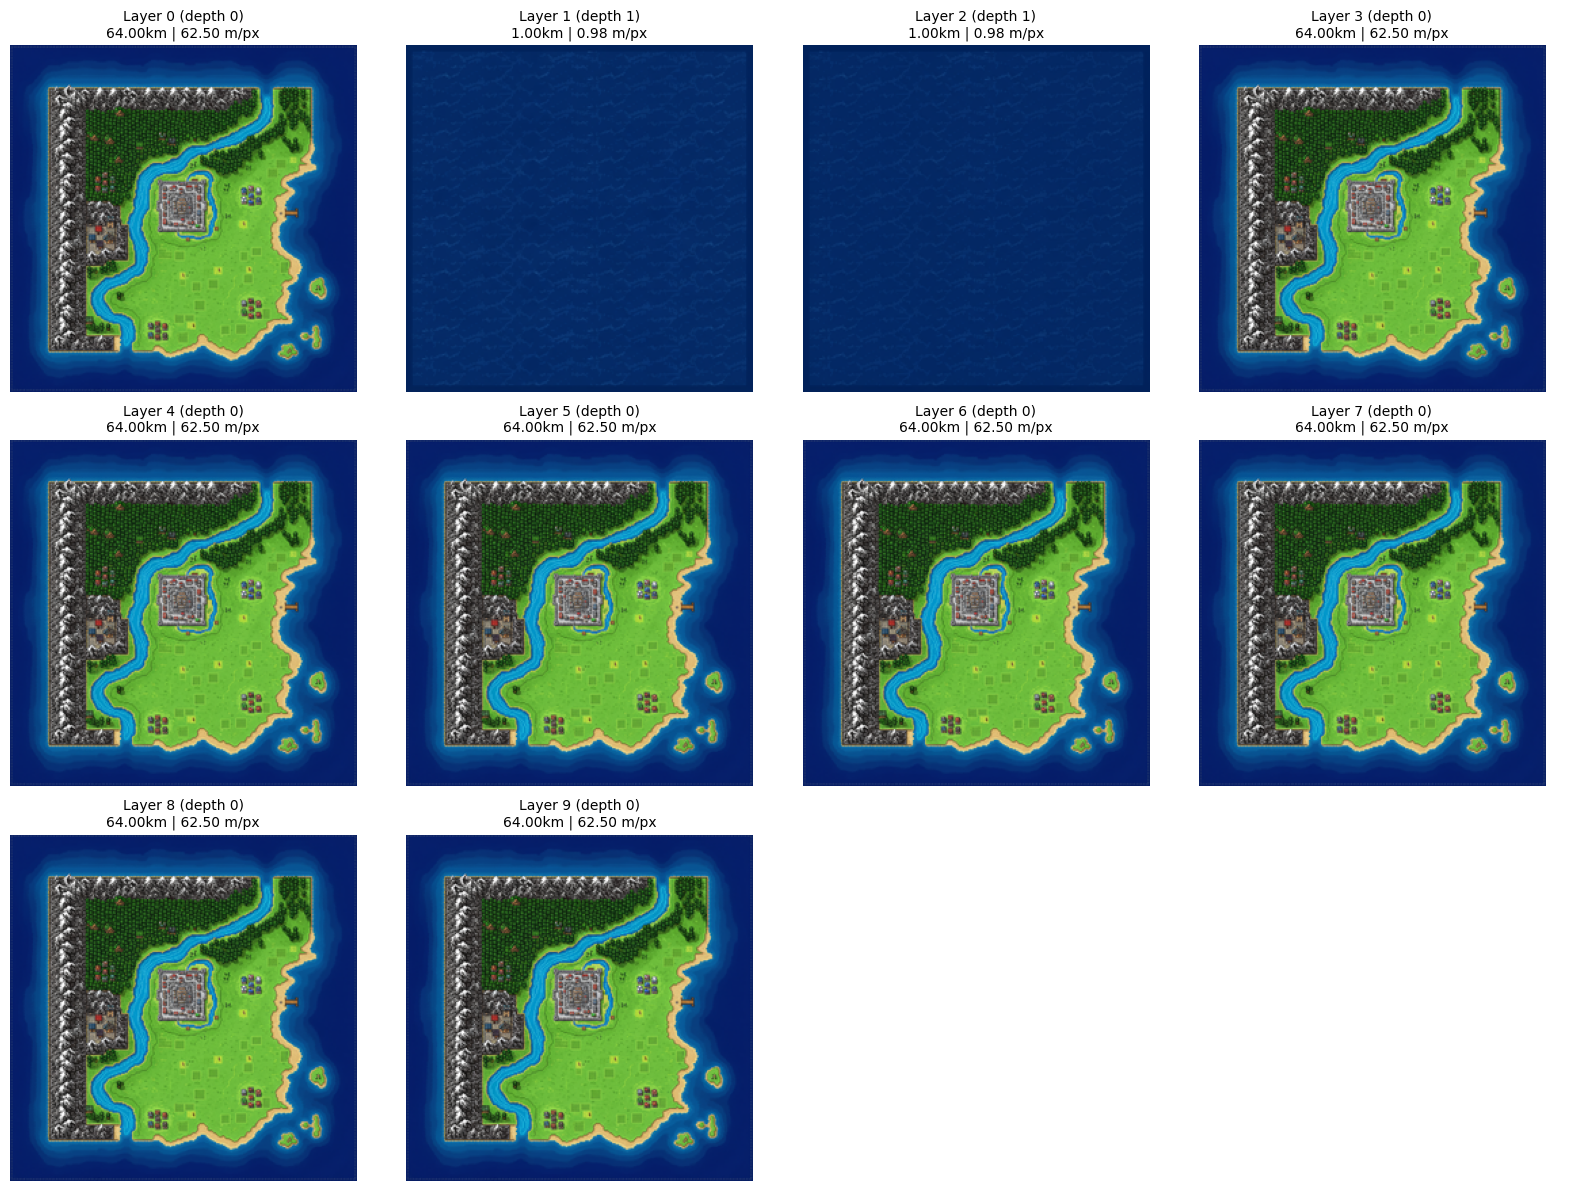


SUMMARY STATISTICS
Maximum depth: 1
Total layers: 12

Layers per depth:
  Depth 0: 10 layers
  Depth 1: 2 layers

Finest detail: 0.9766 m/px


In [55]:
# === ACTIVE WORLD SELECTION ===
ACTIVE_WORLD = "eldermyst"  # <-- CHANGE THIS

# === DISPLAY SETTINGS ===
MAX_LAYERS_TO_SHOW = 10  # Limit display for very deep hierarchies
THUMBNAIL_SIZE = 256  # Size for thumbnail display

# === HELPER FUNCTIONS ===

def show_image(img, title=""):
    if isinstance(img, str):
        img = Image.open(img)
    plt.figure(figsize=(12, 12))
    plt.imshow(img)
    plt.axis('off')
    plt.title(title, fontsize=14, pad=10)
    plt.tight_layout()
    plt.show()

def create_hierarchy_tree(world_name: str):
    """Create text representation of layer hierarchy"""
    data = load_world_data()
    if world_name not in data:
        return None
    
    layers = data[world_name]["layers"]
    if not layers:
        return None
    
    # Build tree structure
    tree_lines = []
    tree_lines.append(f"\n{world_name.upper()} - Layer Hierarchy")
    tree_lines.append("=" * 70)
    
    def add_layer(layer_id, indent=0):
        if layer_id >= len(layers):
            return
        
        layer = layers[layer_id]
        prefix = "  " * indent + ("└─ " if indent > 0 else "")
        
        size_km = layer["size_m"] / 1000
        coords = layer["coordinates"]
        tree_lines.append(
            f"{prefix}Layer {layer_id} (depth {layer['depth']}): "
            f"{size_km:.2f}km × {size_km:.2f}km at ({coords['x_m']}, {coords['y_m']})"
        )
        
        # Add children
        for child_id in layer.get("children", []):
            add_layer(child_id, indent + 1)
    
    # Start with root (layer 0)
    add_layer(0)
    
    tree_lines.append("=" * 70)
    return "\n".join(tree_lines)

def display_layer_grid(world_name: str, max_layers: int = 10):
    """Display all layers in a grid"""
    data = load_world_data()
    if world_name not in data:
        return None
    
    layers = data[world_name]["layers"]
    if not layers:
        return None
    
    num_layers = min(len(layers), max_layers)
    
    # Calculate grid dimensions
    cols = min(4, num_layers)
    rows = (num_layers + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
    if rows == 1 and cols == 1:
        axes = [[axes]]
    elif rows == 1:
        axes = [axes]
    elif cols == 1:
        axes = [[ax] for ax in axes]
    
    for idx in range(rows * cols):
        row = idx // cols
        col = idx % cols
        ax = axes[row][col]
        
        if idx < num_layers:
            layer = layers[idx]
            img = Image.open(layer["image_path"])
            
            # Resize for display
            img_resized = img.resize((THUMBNAIL_SIZE, THUMBNAIL_SIZE), Image.LANCZOS)
            
            ax.imshow(img_resized)
            ax.axis('off')
            
            size_km = layer["size_m"] / 1000
            scale = layer["size_m"] / 1024  # Assuming 1024x1024
            ax.set_title(
                f"Layer {idx} (depth {layer['depth']})\n{size_km:.2f}km | {scale:.2f} m/px",
                fontsize=10
            )
        else:
            ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# === DISPLAY HIERARCHY ===

print("\n" + "="*70)
print(f"STAGE 8: HIERARCHY VIEWER FOR {ACTIVE_WORLD.upper()}")
print("="*70)

data = load_world_data()
if ACTIVE_WORLD not in data:
    print(f"\n❌ World '{ACTIVE_WORLD}' not found!")
    print(f"Available worlds: {', '.join(data.keys())}")
elif not data[ACTIVE_WORLD]["layers"]:
    print(f"\n⚠️  No layers generated yet for {ACTIVE_WORLD}!")
    print("Run Stages 1-2 to generate the world map first.")
else:
    layers = data[ACTIVE_WORLD]["layers"]
    print(f"\nTotal layers: {len(layers)}")
    print(f"World size: {data[ACTIVE_WORLD]['size_meters']/1000:.0f}km × {data[ACTIVE_WORLD]['size_meters']/1000:.0f}km")
    
    # Display hierarchy tree
    tree = create_hierarchy_tree(ACTIVE_WORLD)
    if tree:
        print(tree)
    
    # Layer details
    print("\n" + "="*70)
    print("LAYER DETAILS")
    print("="*70)
    
    for i, layer in enumerate(layers):
        if i >= MAX_LAYERS_TO_SHOW:
            print(f"\n... and {len(layers) - MAX_LAYERS_TO_SHOW} more layers")
            break
        
        size_km = layer["size_m"] / 1000
        scale = layer["size_m"] / 1024
        coords = layer["coordinates"]
        
        print(f"\nLayer {i}:")
        print(f"  Depth: {layer['depth']}")
        print(f"  Size: {size_km:.2f}km × {size_km:.2f}km")
        print(f"  Scale: {scale:.2f} m/px")
        print(f"  Position: ({coords['x_m']}, {coords['y_m']})")
        print(f"  Parent: {layer['parent_id']}")
        print(f"  Children: {len(layer['children'])} tiles")
        print(f"  Image: {layer['image_path']}")
        
        if layer.get("locations"):
            num_locations = len(layer["locations"].get("locations", []))
            print(f"  Locations: {num_locations} detected")
    
    # Display grid of all layers
    print("\n" + "="*70)
    print("VISUAL HIERARCHY")
    print("="*70)
    print(f"Displaying up to {MAX_LAYERS_TO_SHOW} layers...")
    
    display_layer_grid(ACTIVE_WORLD, MAX_LAYERS_TO_SHOW)
    
    # Summary statistics
    print("\n" + "="*70)
    print("SUMMARY STATISTICS")
    print("="*70)
    
    max_depth = max(layer["depth"] for layer in layers)
    layers_by_depth = {}
    for layer in layers:
        depth = layer["depth"]
        if depth not in layers_by_depth:
            layers_by_depth[depth] = 0
        layers_by_depth[depth] += 1
    
    print(f"Maximum depth: {max_depth}")
    print(f"Total layers: {len(layers)}")
    print(f"\nLayers per depth:")
    for depth in sorted(layers_by_depth.keys()):
        print(f"  Depth {depth}: {layers_by_depth[depth]} layers")
    
    # Calculate total coverage
    finest_scale = min(layer["size_m"] / 1024 for layer in layers)
    print(f"\nFinest detail: {finest_scale:.4f} m/px")
    
    # Count locations if any
    total_locations = 0
    for layer in layers:
        if layer.get("locations"):
            total_locations += len(layer["locations"].get("locations", []))
    
    if total_locations > 0:
        print(f"Total locations detected: {total_locations}")

---
# 📚 Quick Reference
---

## Complete 10-Stage Pipeline

### Core Workflow (Stages 0-2)
1. **Stage 0**: Configure models, parameters, and 8 story bibles
2. **Stage 1**: Generate world prompt using reasoning model
3. **Stage 2**: Generate world image (entire map at layer 0)

### Location Detection (Stage 3-4) 🆕
4. **Stage 3**: Auto Cropper - Detect all locations with 16×16 grid + structured outputs
5. **Stage 4**: Crop Viewer - View manual or location-based crops

### Tile Generation (Stages 5-7)
6. **Stage 5**: Generate tile prompt for zoomed region
7. **Stage 6**: Generate tile image using prompt + parent context
8. **Stage 7**: Context-aware generation (complete pipeline with siblings)

### Visualization (Stage 8)
9. **Stage 8**: Hierarchy Viewer - Visualize all layers and statistics

---

## Key Features

### LiteLLM Integration ✓
- Unified API for all model calls
- Model format: `openrouter/google/gemini-2.5-flash`
- Simplified error handling and response parsing
- Built-in structured outputs support

### Auto Location Detection ✓
- 16×16 grid overlay (columns A-P, rows 1-16)
- Gemini 2.5 Flash with thinking for detection
- Pydantic models for type-safe structured outputs
- Location-based cropping for intelligent tile selection
- Gridded debug images for validation

### Hierarchical Generation ✓
- 64× zoom factor between layers
- Parent context for consistency
- Sibling awareness for adjacent tiles
- Automatic layer tracking in `world_data.json`

### 8 Story Bibles ✓
- `eldermyst` - Temperate fantasy continent
- `sunscorch` - Vast desert expanse
- `thousand_isles` - Archipelago world
- `frostheim` - Frozen tundra
- `pyroclasm` - Volcanic wasteland
- `verdant_crown` - Dense rainforest
- `skyreach` - Floating islands
- `ashfall_wastes` - Post-apocalyptic ruins

---

## Usage Tips

### Switching Worlds
Change `ACTIVE_WORLD = "eldermyst"` at the top of each stage cell

### Location-Based Cropping
In Stage 4, set `CROP_BY_LOCATION = "Thornhaven"` to auto-crop to a detected location

### Caching
- All API calls are cached in `outputs/cache_litellm/`
- Delete cache files to regenerate
- Set `USE_CACHE = False` to disable

### World Data
- Central tracking file: `outputs/world_data.json`
- Contains all layers, coordinates, and location data
- Hierarchy relationships (parent/children)

---

## File Structure

```
outputs/
  ├── world_data.json          # Central tracking file
  ├── cache_litellm/            # API response cache
  ├── grids/                    # Gridded debug images
  ├── tiles/                    # Generated tile images
  └── {world}_layer0_*.png      # World maps
```

---

## Models Used

- **Reasoning**: `openrouter/google/gemini-2.5-flash` (prompt generation, location detection)
- **Image**: `openrouter/google/gemini-2.5-flash-image` (map generation)
- **Thinking**: Enabled with 10k token budget for both

---

## Next Steps

1. Generate world maps for all 8 story bibles (Stages 1-2)
2. Run auto cropper on each world (Stage 3)
3. Generate tiles for locations of interest (Stages 5-7)
4. Build full hierarchy with multiple zoom levels
5. Visualize complete hierarchy (Stage 8)